# Flattening echelle spectra
Often-times, the model spectrum is just not good enough to get an adequate fit using the normal Fitters.RVFitter. When that is the case, the automated flattening just doesn't work. Let's give this a shot without using models. The thing we want to minimize is the offset between the flux at one order and the flux in the adjacent order. 

$$L = \sum_{i=1}^{N_{orders}-1} \left(\frac{O_i(\lambda)}{M(i, \lambda| \Theta)} - \frac{O_{i+1}(\lambda)}{M(i+1, \lambda | \theta)}\right)^2 $$ 

Where $M(i, \lambda | \theta)$ is perhaps a 2d polynomial function of some order where $i$ is for the order number, $\lambda$ is the wavelength (or maybe pixel number?), and the $\theta$ are all the polynomial coefficients.

# TRY:
  Try using Robust Linear Models from statsmodels. That might help it to ignore the big Balmer line. I will need to put the Chebyshev factors into a feature vector to use this...
  
  Those might help a bit. How about a hybrid approach where I divide by a stellar model (or empirical spectrum of similar type as Adam suggests), and then do a full robust 2D fit.
  
# Robust linear models works well enough for me!
I was able to sufficiently flatten a few of my spectra to get RV fits. I need to calibrate the RV though, so pretty much need to flatten every spectrum and fit the RV. This will take a while...

In [1]:
import SpecFlattener
import glob
import StarData
from astropy.io import fits
import SpectralTypeRelations
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#hdf5_lib = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid_full.hdf5'
hdf5_lib = '/Volumes/DATADRIVE/Kurucz_Grid/TS23_grid_full.hdf5'
star_list = [f for f in glob.glob('../201*/H*.fits') if 'smoothed' not in f and 
             'uncorrected' not in f and 'flattened' not in f and 'B.fits' not in f]
print(len(star_list))
#star_list.index('../20131019/HIP_22913.fits')
for s in star_list:
    print s

144
../20130106/HIP_28691.fits
../20130107/HIP_16147.fits
../20130107/HIP_18724.fits
../20130107/HIP_21402.fits
../20130107/HIP_25048.fits
../20130107/HIP_25281.fits
../20130107/HIP_28614.fits
../20130107/HIP_29038.fits
../20130107/HIP_3300.fits
../20130107/HIP_36850_A.fits
../20130107/HIP_45688.fits
../20130107/HIP_55266.fits
../20130107/HIP_55434.fits
../20130823/HIP_116971.fits
../20130824/HIP_116805.fits
../20131017/HIP_101716.fits
../20131017/HIP_14576.fits
../20131017/HIP_15444.fits
../20131018/HIP_111841.fits
../20131018/HIP_116631.fits
../20131018/HIP_118243.fits
../20131018/HIP_12719.fits
../20131018/HIP_14576.fits
../20131018/HIP_16244.fits
../20131018/HIP_2912.fits
../20131018/HIP_98194.fits
../20131018/HIP_99080.fits
../20131019/HBC_722.fits
../20131019/HIP_106711.fits
../20131019/HIP_12706.fits
../20131019/HIP_97496.fits
../20131020/HIP_105966.fits
../20131020/HIP_111169.fits
../20131020/HIP_1366.fits
../20131020/HIP_18805.fits
../20131020/HIP_3881.fits
../20131020/HIP_443

In [3]:
# Guess stellar properties
MS = SpectralTypeRelations.MainSequence()
def guess_teff_logg(fname):
    header = fits.getheader(fname)
    data = StarData.GetData(header['OBJECT'])
    spt = data.spectype
    teff = MS.Interpolate('Temperature', spt)
    logg = 3.5 if 'I' in spt else 4.0
    return teff, logg

In [80]:
teff, logg = guess_teff_logg('../20131021/HIP_109521.fits')
print(teff, logg)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


(array(8079.999999999998), 4.0)


INFO:root:Initializing continuum for RV guess.
INFO:root:Estimating the RV and vsini by cross-correlation


Determine Chunk Log: Wl is 131072
Warning, 1996 of 1996 bins contained negative fluxes; they have been set to zero.

INFO:root:T = 8178.93960024
logg = 3.84080221678
RV = -100.0
INFO:root:LogL = -88140997.3266

INFO:root:T = 8179.03960024
logg = 3.84080221678
RV = -100.0
INFO:root:LogL = -88375191.6723

INFO:root:T = 8178.93960024
logg = 3.94080221678
RV = -100.0
INFO:root:LogL = -87605511.767

INFO:root:T = 8178.93960024
logg = 3.84080221678
RV = -99.9
INFO:root:LogL = -88363871.2827

INFO:root:T = 7000.0
logg = 4.5
RV = -100.0
INFO:root:LogL = -87256894.1132

INFO:root:T = 7000.1
logg = 4.5
RV = -100.0
INFO:root:LogL = -87250341.3278

INFO:root:T = 7000.0
logg = 4.6
RV = -100.0
INFO:root:LogL = -87634892.6582

INFO:root:T = 7000.0
logg = 4.5
RV = -99.9
INFO:root:LogL = -87232399.2596

INFO:root:T = 7780.5926732
logg = 4.0635357743
RV = -100.0
INFO:root:LogL = -76708174.915

INFO:root:T = 7780.6926732
logg = 4.0635357743
RV = -100.0
INFO:root:LogL = -76709224.4276

INFO:root:T = 7780.5926732
logg = 4.1635357743
RV = -100.0
INFO:root:LogL = -75243775.9745

INFO:root:T = 7780.5926732
logg = 4.06353577

<IPython.core.display.Javascript object>


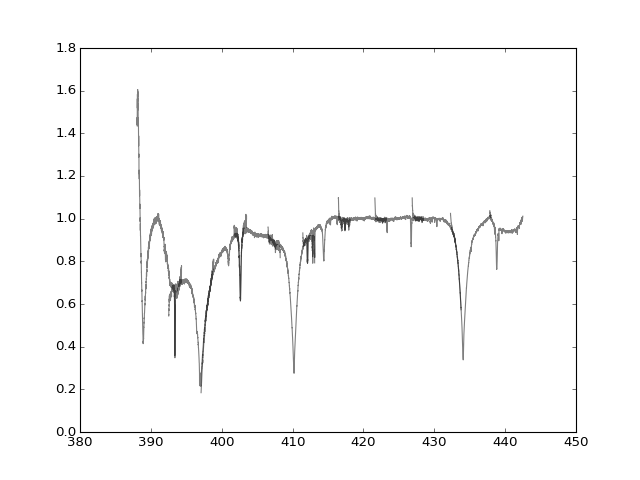

In [104]:
reload(SpecFlattener)
reload(StellarModel)
output = SpecFlattener.flatten_spec(star_list[1], hdf5_lib, teff=teff, logg=logg, normalize_model=False,
                                       first_order=0, last_order=15)
final_orders, flattened, shifted_orders, mcf = output

%matplotlib notebook
for order in final_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.5)

<IPython.core.display.Javascript object>


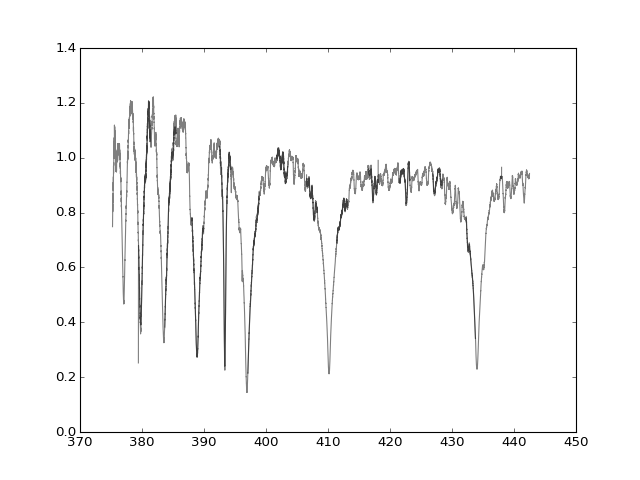

In [102]:

%matplotlib notebook
for order in flattened:
    plt.plot(order.x, order.y, 'k-', alpha=0.5)